In [1]:
#!pip install rdkit
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install torch_geometric

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.stats import pearsonr

In [3]:
df = pd.read_csv("C:\\itmo\\BONUS TRACK\\final_project\\data\\NN_ML.csv", delimiter=",")
df.head(10)

,serial_number,name,dft_gibbs_free_energy_ev,dft_electronic_energy_ev,dft_entropy_ev,dft_enthalpy_ev,dft_dipole_moment_d,dft_homo_ev,dft_lumo_ev,hf_gibbs_free_energy_ev,hf_electronic_energy_ev,hf_entropy_ev,hf_enthalpy_ev,hf_dipole_moment_d,hf_homo_ev,hf_lumo_ev,mass_au
0,20122-M-BA1,002-M-BA1-b,-27617.109263,-27623.001175,1.877779,-27615.231484,1.47466,-6.2925,-1.4983,-27275.077354,-27281.889686,1.795316,-27273.282037,0.87236,-8.8130,4.0489,282.26
1,NaN,002-M-BA1-pipi,-27617.108570,-27623.064075,1.822257,-27615.286313,1.69901,-6.7665,-1.3131,-27275.129804,-27281.953771,1.772166,-27273.357638,1.19181,-9.2580,4.4306,282.26
2,20204-M-CA-UA-CR,005-MEL-CA,-25917.873424,-25922.092247,1.641525,-25916.231899,0.85984,-6.4902,-0.8343,-25599.450712,-25604.306366,1.564143,-25597.886569,0.93514,-8.9909,4.6443,255.20
3,NaN,006-MEL-UA,-29496.321269,-29501.225342,1.791889,-29494.529380,3.15832,-6.1902,-1.1975,-29133.285511,-29138.980259,1.668533,-29131.616979,2.68196,-8.2371,3.9070,294.24
4,NaN,007-MEL-CR,-22922.503656,-22927.783754,1.687934,-22920.815722,6.66567,-6.3708,-0.2151,-22635.216753,-22641.290325,1.651416,-22633.565337,6.85797,-8.6600,5.1451,239.24
5,20104-BA-tAPYR,003a-pos3,-25042.258496,-25047.041819,1.688861,-25040.569635,1.80279,-5.6022,-1.5789,-24733.005941,-24738.528929,1.624539,-24731.381402,1.75174,-7.9515,3.9340,253.22
6,NaN,003-pos3,-25042.235099,-25047.057346,1.661966,-25040.573133,2.04241,-5.8804,-1.3353,-24733.010851,-24738.542156,1.608890,-24731.401961,1.48450,-8.2321,4.3568,253.22
7,NaN,004b-pos4,-25042.548432,-25047.359472,1.657525,-25040.890907,2.35875,-5.6696,-1.6393,-24733.322882,-24738.880448,1.601993,-24731.720889,2.21294,-8.0242,3.9335,253.22
8,NaN,005-POS6,-36751.548195,-36759.575217,2.212176,-36749.336020,3.29897,-5.6196,-1.5003,-36294.244926,-36303.458175,2.114652,-36292.130274,2.35750,-7.8848,3.9491,378.36
9,NaN,008a-pos8,-36751.835822,-36759.884948,2.188969,-36749.646853,2.41814,-5.5673,-1.6099,-36294.554543,-36303.799373,2.095823,-36292.458720,2.07808,-7.9704,3.9298,378.36


In [4]:
"""Загрузка данных"""
# Функция read_xyz_file() читает .xyz-файлы (типы атомов + координаты)
# Функция check_valence() проверяет валентность атомов
# Функция xyz_to_rdkit_mol() конвертирует .xyz данные в RDKit-молекулы (добавляет связи для атомов < 1.3 A; если связь нарушает валентность - удаляет)

def read_xyz_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[2:] 
        coordinates = []
        elements = []
        for line in lines:
            parts = line.split()
            element = parts[0]
            x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
            elements.append(element)
            coordinates.append([x, y, z])
    return elements, coordinates

def check_valence(mol, atom_idx):
    try:
        Chem.SanitizeMol(mol)
        return True
    except Chem.AtomValenceException:
        return False

def xyz_to_rdkit_mol(elements, coordinates):
    mol = Chem.RWMol()
    conf = Chem.Conformer(len(elements))
    
    for i, element in enumerate(elements):
        atom = Chem.Atom(element)
        mol.AddAtom(atom)
        conf.SetAtomPosition(i, Chem.rdGeometry.Point3D(*coordinates[i]))

    mol.AddConformer(conf)
    
    num_atoms = len(elements)
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
            if distance < 1.3:
                mol.AddBond(i, j, Chem.BondType.SINGLE)
                if not check_valence(mol, i) or not check_valence(mol, j):
                    mol.RemoveBond(i, j)
    
    try:
        Chem.SanitizeMol(mol)
        mol = Chem.AddHs(mol) 
        Chem.SanitizeMol(mol)
    except Chem.AtomValenceException as e:
        print(f"Valence error for molecule: {e}")
        return None
    except Chem.AtomSanitizeException as e:
        print(f"Sanitization error for molecule: {e}")
        return None
    
    return mol

In [5]:
"""Загрузка данных"""
# Функция прводит вычисления RDKit признаков для каждой молекулы

def compute_rdkit_features(mol):
    if mol is None:
        return None
    morgan_fp = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return np.array(morgan_fp)

In [6]:
"""Загрузка данных"""
# Функция для графового представления БД
# HF-3с столбцы & RdKit-столбец - признаки нодов
# Порог в 3.0 А установлен для эджей  
# Добавил DFT энергии (таргеты) в качестве меток

def create_graph_data(df):
    graph_data_list = []
    
    for idx, row in df.iterrows():
        coordinates = np.array(row['coordinates'])
        num_atoms = coordinates.shape[0]

        hf_features = row[['hf_gibbs_free_energy_ev', 'hf_electronic_energy_ev', 'hf_entropy_ev',
                           'hf_enthalpy_ev', 'hf_dipole_moment_d', 'hf_homo_ev', 'hf_lumo_ev', 'mass_au']].astype(float).values

        rdkit_features = row['rdkit_features']
        if rdkit_features is not None:
            hf_features = np.concatenate([hf_features, rdkit_features])

        node_features = np.tile(hf_features, (num_atoms, 1))
        node_features = torch.tensor(node_features, dtype=torch.float)

        edge_index = []
        for i in range(num_atoms):
            for j in range(i + 1, num_atoms):
                distance = np.linalg.norm(coordinates[i] - coordinates[j])
                if distance < 3.5:
                    edge_index.append([i, j])
                    edge_index.append([j, i])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        
        graph_data = Data(x=node_features, edge_index=edge_index)
        graph_data.y = torch.tensor(row[['dft_gibbs_free_energy_ev', 'dft_electronic_energy_ev', 'dft_entropy_ev',
                                         'dft_enthalpy_ev', 'dft_dipole_moment_d', 'dft_homo_ev', 'dft_lumo_ev']].astype(float).values, dtype=torch.float)
        graph_data_list.append(graph_data)
    
    return graph_data_list

In [7]:
"""Загрузка данных"""
# Добавил столбцы с координатами и атомами

xyz_folder = "C:/itmo/BONUS TRACK/final_project/xyz"

df['coordinates'] = [[] for _ in range(len(df))]
df['elements'] = [[] for _ in range(len(df))]

for idx, row in df.iterrows():
    file_name = f"{row['name']}.xyz"
    file_path = os.path.join(xyz_folder, file_name)
    if os.path.exists(file_path):
        elements, coordinates = read_xyz_file(file_path)
        df.at[idx, 'coordinates'] = coordinates
        df.at[idx, 'elements'] = elements

In [8]:
"""Загрузка данных"""
# Добавил столбец с RDKit-признаками

df['rdkit_features'] = df.apply(lambda row: compute_rdkit_features(xyz_to_rdkit_mol(row['elements'], row['coordinates'])), axis=1)

In [9]:
"""Загрузка данных"""
# Список графов

graph_data_list = create_graph_data(df)

In [10]:
"""Загрузка данных"""
# У первого графа 34 нод, а количество крпизнаков у ноды = 2056 (2048 фингерпринтов + 7 HF-3c столбцов + mass_au)
# Каждый эдж представлен двумя нодами, а общее количество эджей в графе = 310 
# 7 - количество таргетов

graph_data_list[0]

Data(x=[34, 2056], edge_index=[2, 310], y=[7])

In [11]:
"""Загрузка данных"""
# Графы были сгенерированы для каждого наблюдения 
# Проверяю количество графов 

num_graphs = len(graph_data_list)
print(f"Number of graphs: {num_graphs}")

Number of graphs: 1056


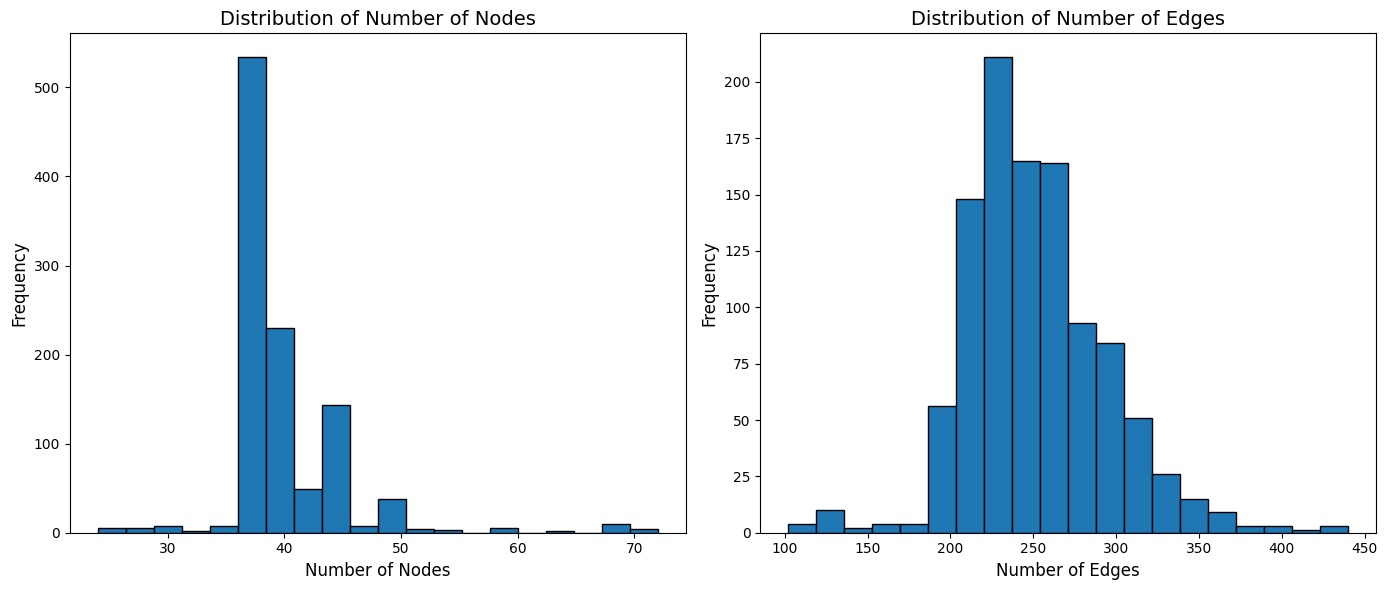

In [12]:
"""Разведочный анализ данных (EDA)"""
# Визуализирую распределение количества нодов и эджей для каждого графа

num_nodes = []
num_edges = []

for graph_data in graph_data_list:
    num_nodes.append(graph_data.num_nodes)
    num_edges.append(graph_data.num_edges // 2) 

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(num_nodes, bins=20, edgecolor='black')
plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Number of Nodes', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1, 2, 2)
plt.hist(num_edges, bins=20, edgecolor='black')
plt.xlabel('Number of Edges', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Number of Edges', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

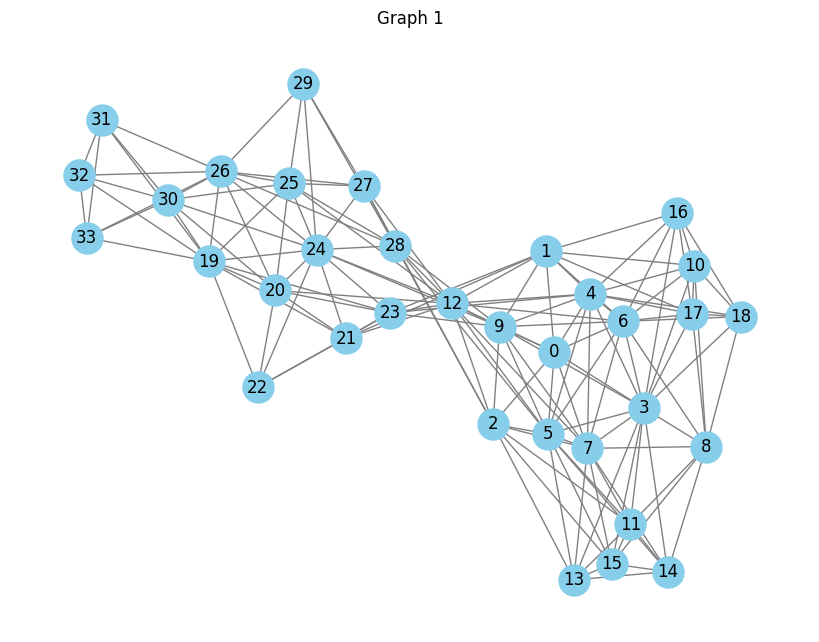

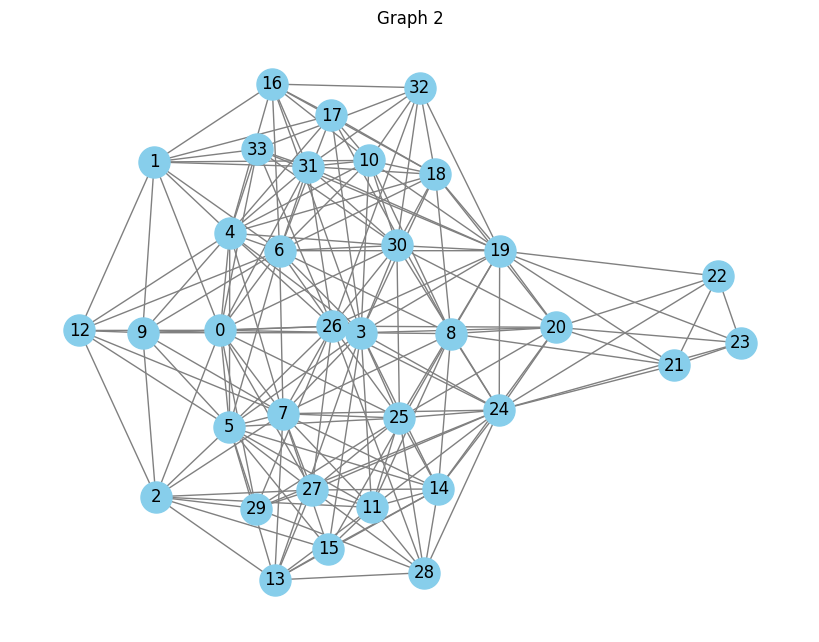

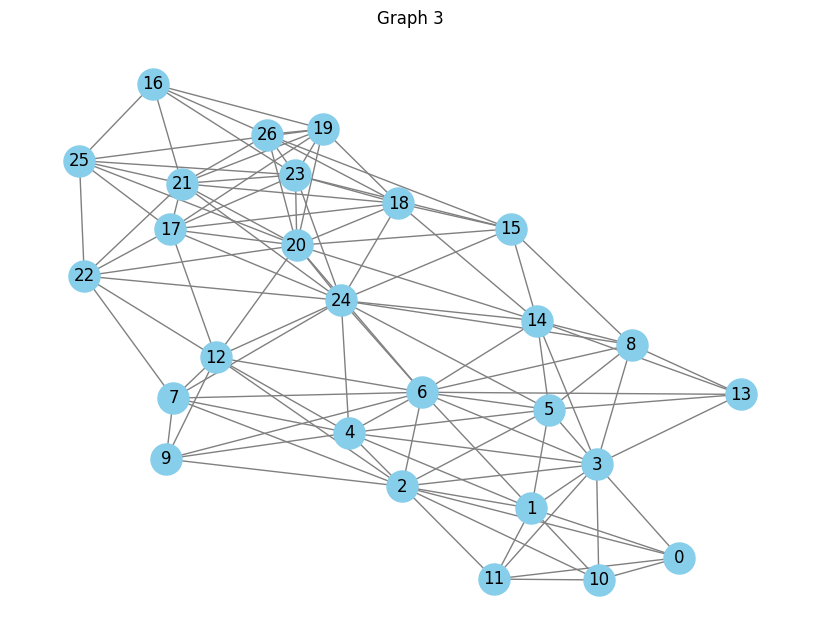

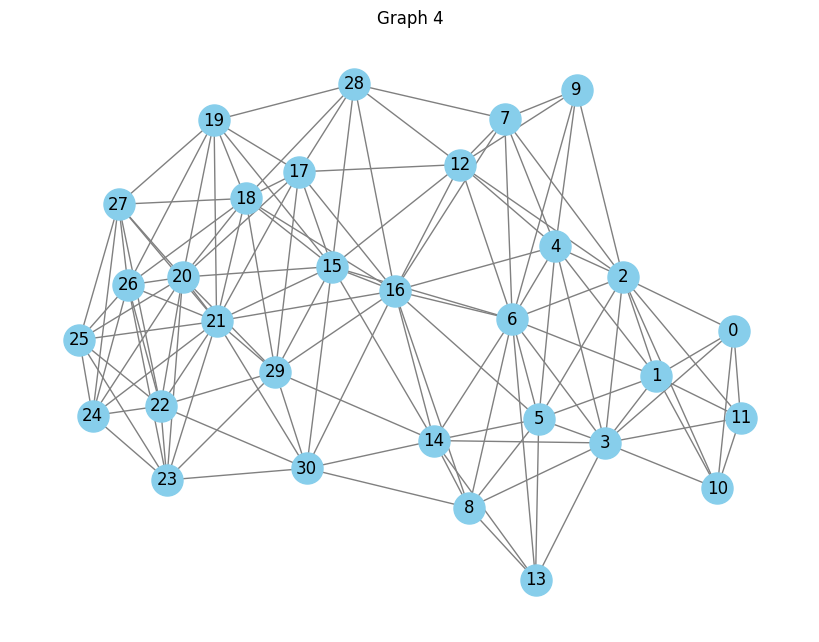

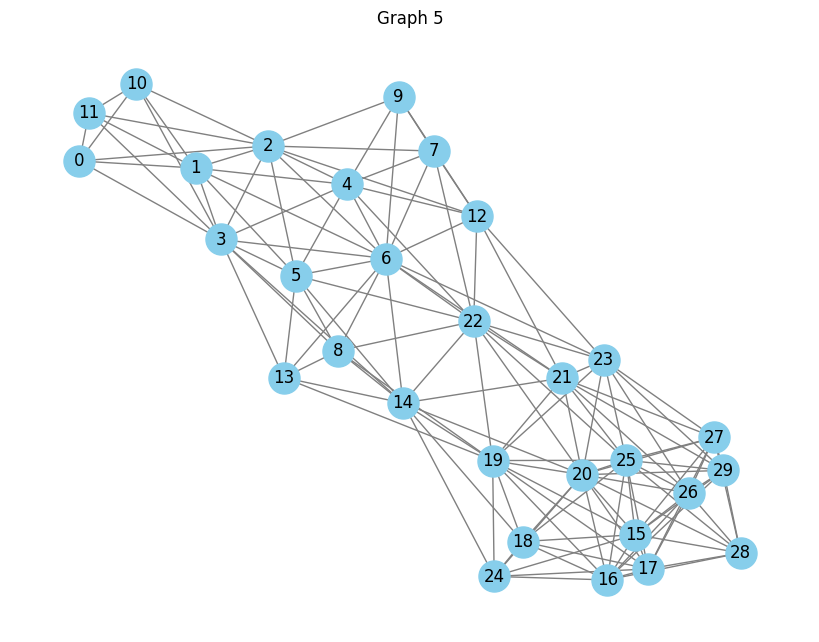

In [13]:
"""Разведочный анализ данных (EDA)"""
# Визуализирую первые 5 графов

num_graphs_to_visualize = 5

for i in range(num_graphs_to_visualize):
    graph_data = graph_data_list[i]
    num_nodes = graph_data.num_nodes
    edge_index = graph_data.edge_index.numpy().T
    
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edge_index)
    
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G) 
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', linewidths=1, font_size=12)
    plt.title(f'Graph {i+1}')
    plt.show()

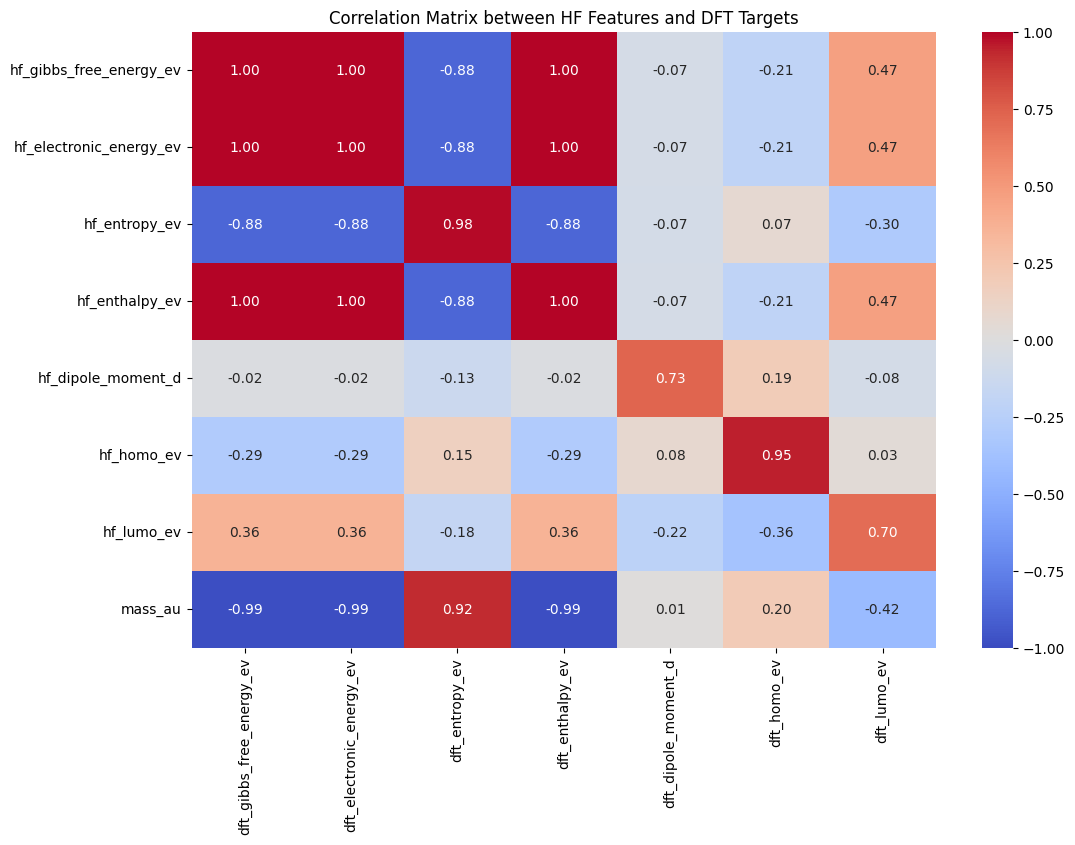

In [14]:
"""Разведочный анализ данных (EDA)"""
# Матрица корреляции признаков нод (HF-3c признаков + mass_au) и таргетов (DFT)

hf_features = ['hf_gibbs_free_energy_ev', 'hf_electronic_energy_ev', 'hf_entropy_ev',
               'hf_enthalpy_ev', 'hf_dipole_moment_d', 'hf_homo_ev', 'hf_lumo_ev', 'mass_au']
dft_features = ['dft_gibbs_free_energy_ev', 'dft_electronic_energy_ev', 'dft_entropy_ev',
                'dft_enthalpy_ev', 'dft_dipole_moment_d', 'dft_homo_ev', 'dft_lumo_ev']


correlation_matrix = df[hf_features + dft_features].corr().loc[hf_features, dft_features]

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix between HF Features and DFT Targets')
plt.show()

In [15]:
"""Разведочный анализ данных (EDA)"""
# Cредняя абсолютная корреляция каждого HF-3c признака с любым таргетом DFT
# Максимальная абсолютная корреляция каждого HF-3c признака с любым таргетом DFT

average_correlations = correlation_matrix.abs().mean(axis=1)
ranked_features_avg = average_correlations.sort_values(ascending=False)
print("\nHF features ranked by average absolute correlation:\n",ranked_features_avg)

max_correlations = correlation_matrix.abs().max(axis=1)
ranked_features_max = max_correlations.sort_values(ascending=False)
print("\nHF features ranked by maximum absolute correlation:\n",ranked_features_max)


HF features ranked by average absolute correlation:
 hf_enthalpy_ev             0.660735
hf_gibbs_free_energy_ev    0.660735
hf_electronic_energy_ev    0.660711
mass_au                    0.644213
hf_entropy_ev              0.580111
hf_lumo_ev                 0.363926
hf_homo_ev                 0.296569
hf_dipole_moment_d         0.171076
dtype: float64

HF features ranked by maximum absolute correlation:
 hf_electronic_energy_ev    1.000000
hf_gibbs_free_energy_ev    1.000000
hf_enthalpy_ev             1.000000
mass_au                    0.985962
hf_entropy_ev              0.984947
hf_homo_ev                 0.948752
hf_dipole_moment_d         0.731590
hf_lumo_ev                 0.698479
dtype: float64


In [16]:
"""Разведочный анализ данных (EDA)"""
# Функция для гистограмм распределения значений

def plot_histograms(features, title):
    n_cols = 3
    n_rows = (len(features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    fig.suptitle(title, fontsize=20)

    for i, feature in enumerate(features):
        ax = axes[i // n_cols, i % n_cols]
        ax.hist(df[feature], bins=30, edgecolor='k', alpha=0.7)
        ax.set_title(feature)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    for i in range(len(features), n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

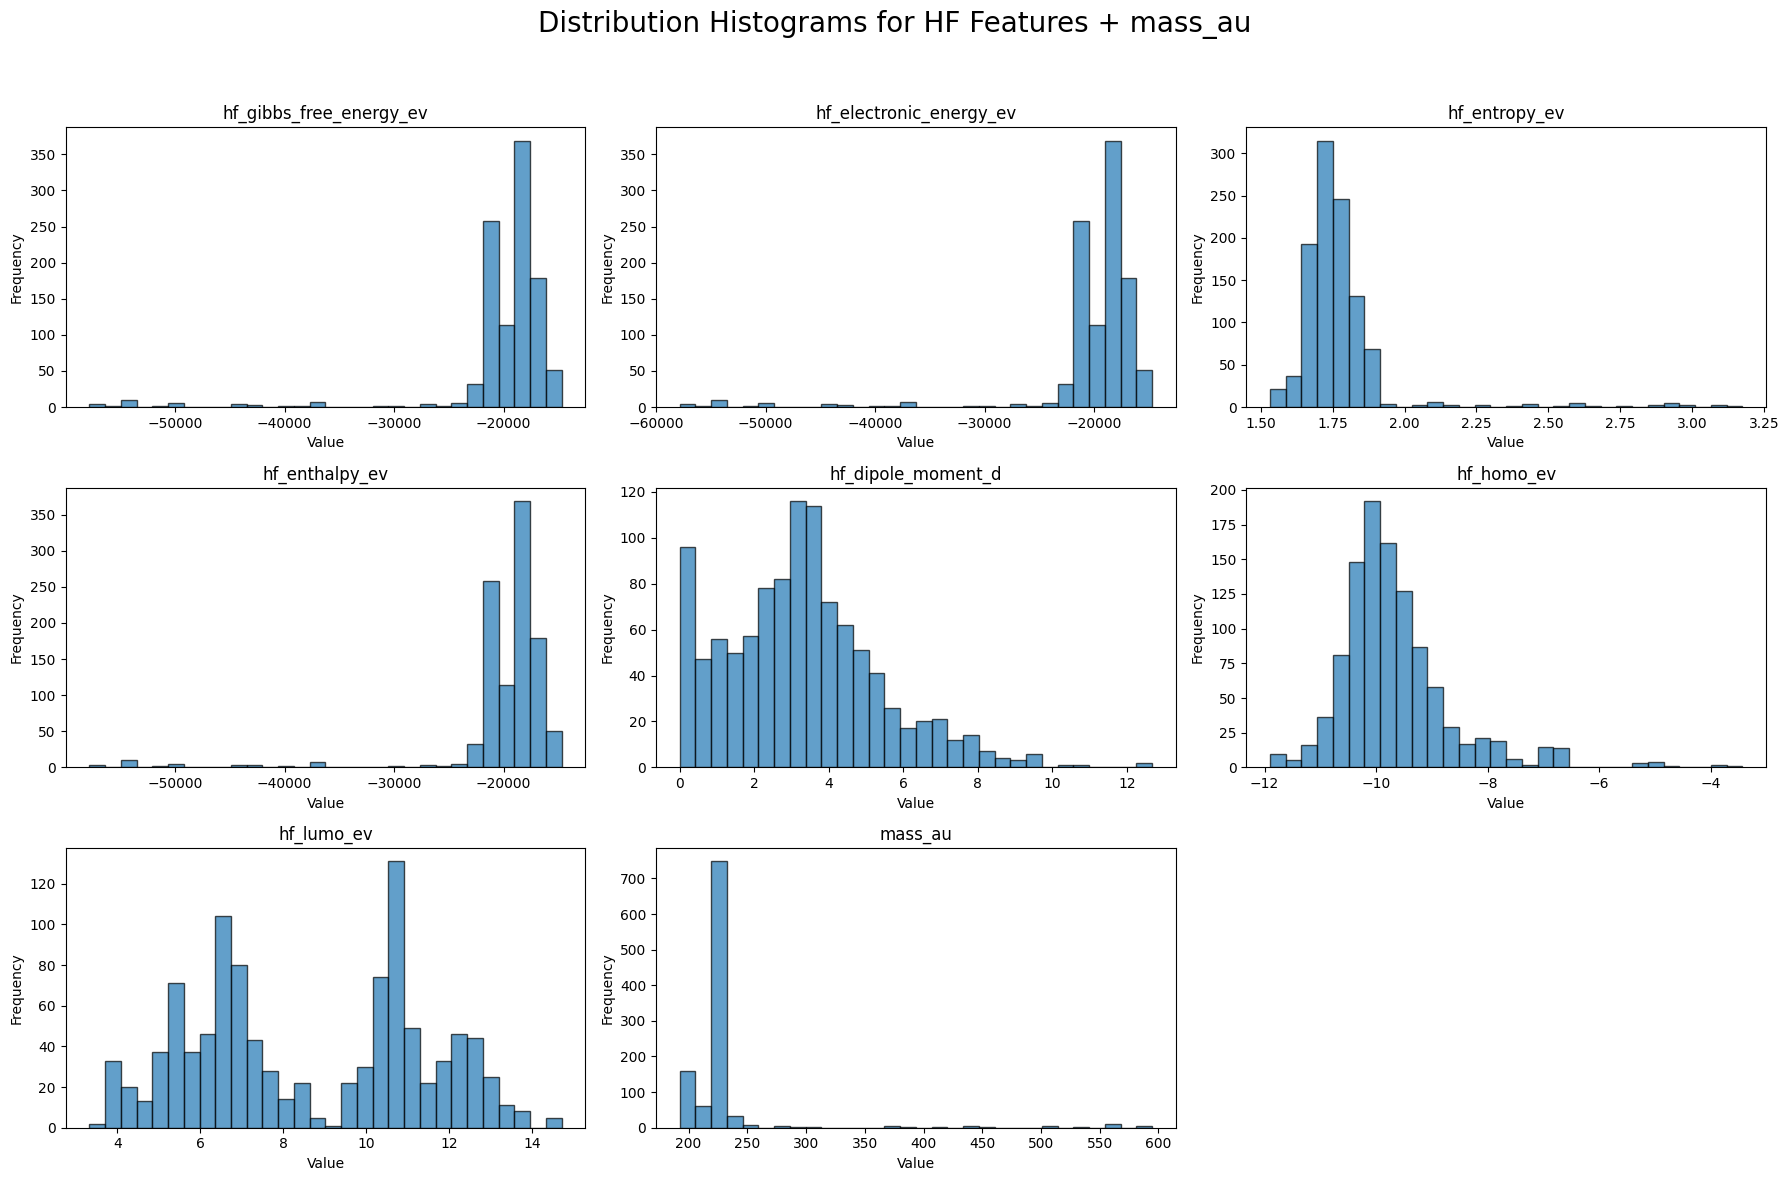

In [17]:
"""Разведочный анализ данных (EDA)"""
# HF-3c (гистограммы распределения)

plot_histograms(hf_features, 'Distribution Histograms for HF Features + mass_au')

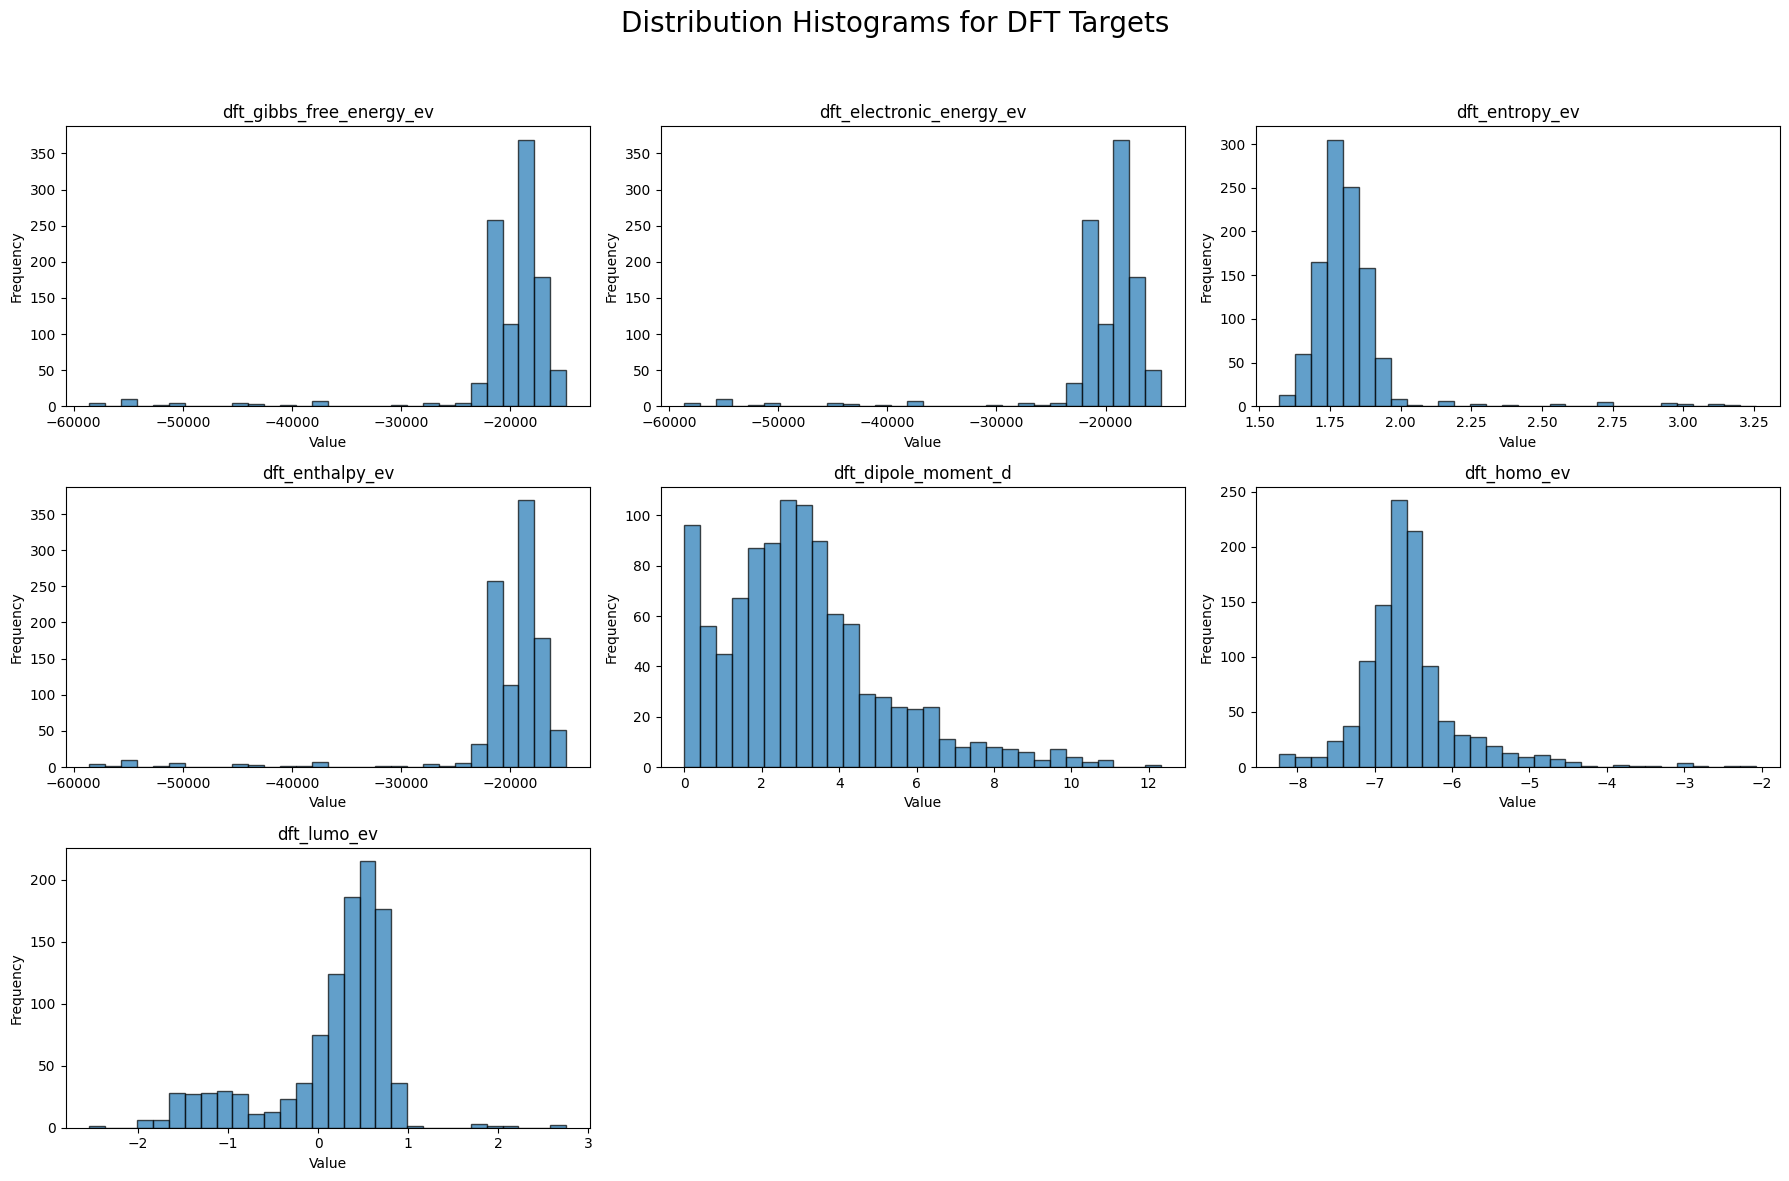

In [18]:
"""Разведочный анализ данных (EDA)"""
# DFT (гистограммы распределения)

plot_histograms(dft_features, 'Distribution Histograms for DFT Targets')

In [19]:
"""Разведочный анализ данных (EDA)"""
# Функция для диаграмм "Ящик с усами"

def plot_boxplots(features, title):
    n_cols = 3
    n_rows = (len(features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    fig.suptitle(title, fontsize=20)

    for i, feature in enumerate(features):
        ax = axes[i // n_cols, i % n_cols]
        ax.boxplot(df[feature].dropna(), vert=True, patch_artist=True)
        ax.set_title(feature)
        ax.set_ylabel('Value')

    for i in range(len(features), n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

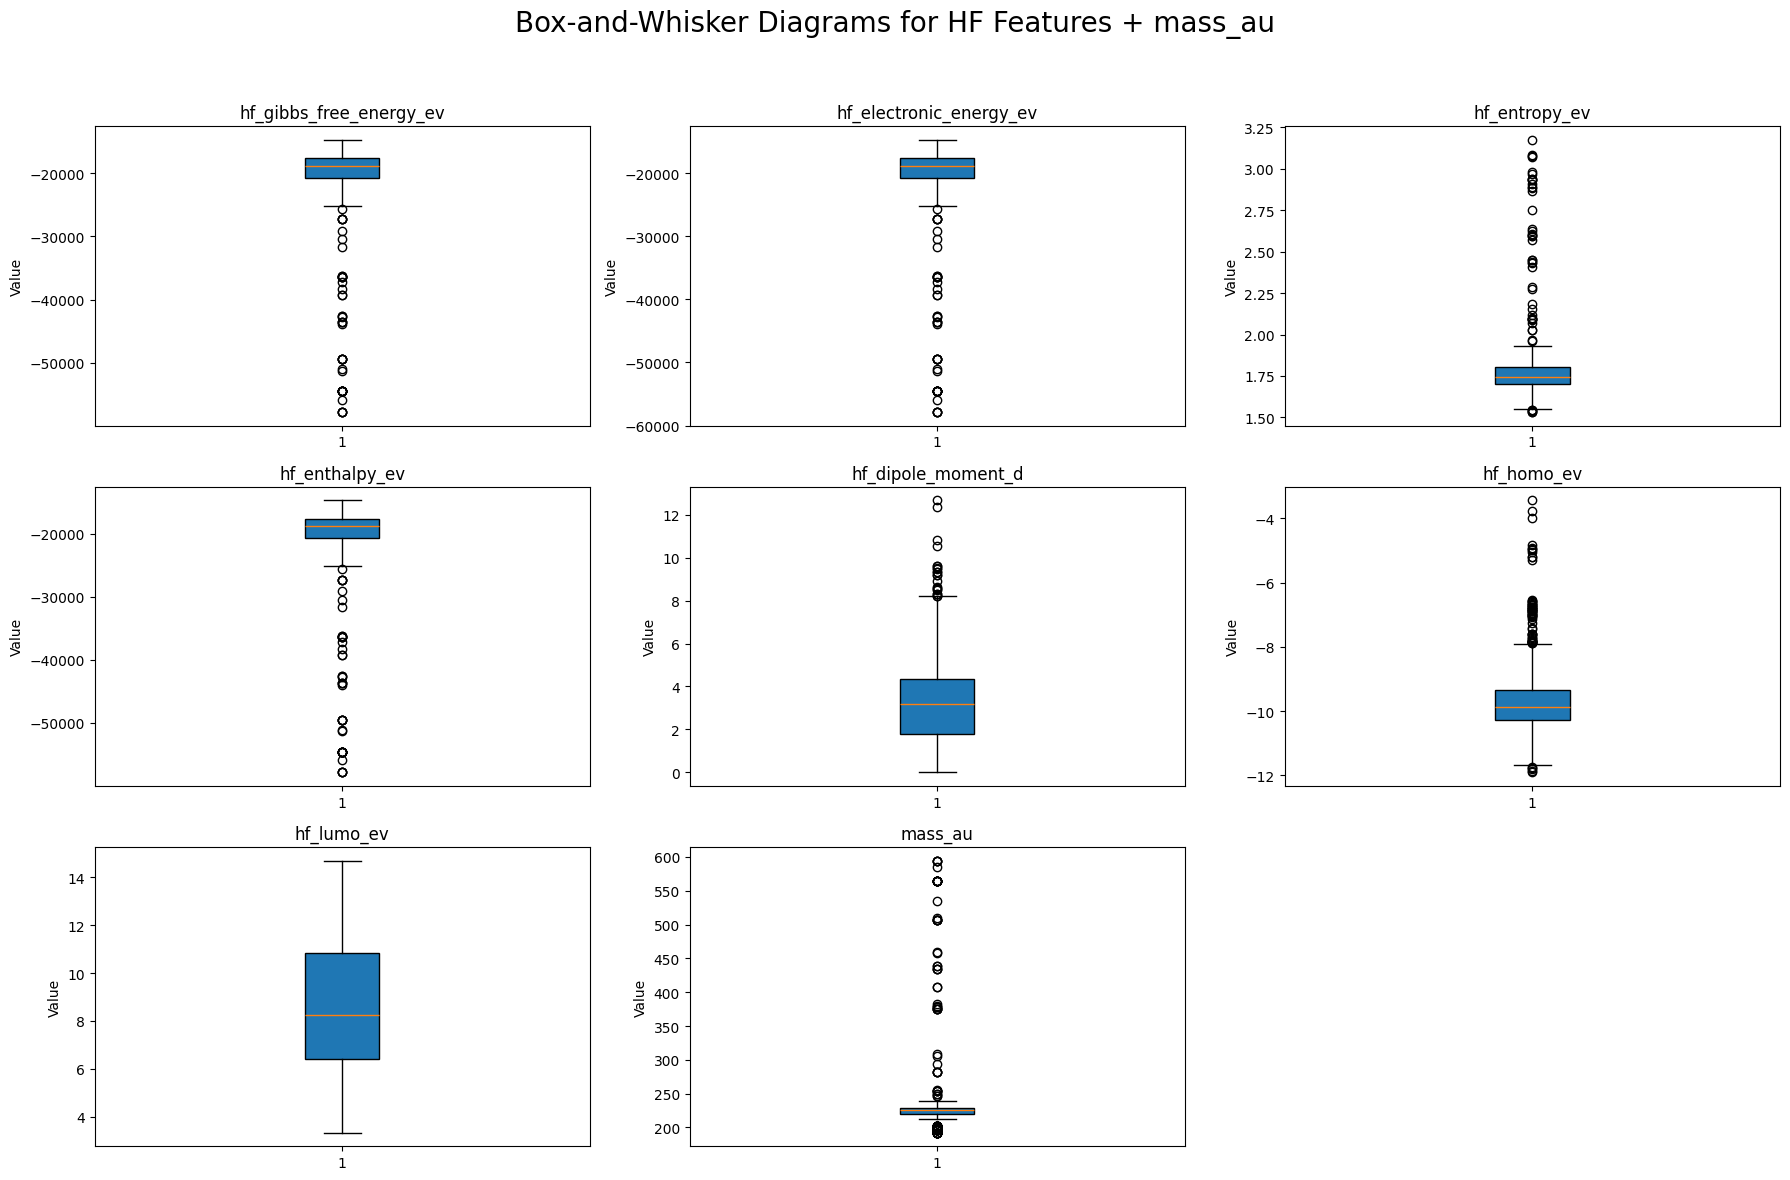

In [20]:
"""Разведочный анализ данных (EDA)"""
# HF-3c ("Ящик с усами")

plot_boxplots(hf_features, 'Box-and-Whisker Diagrams for HF Features + mass_au')

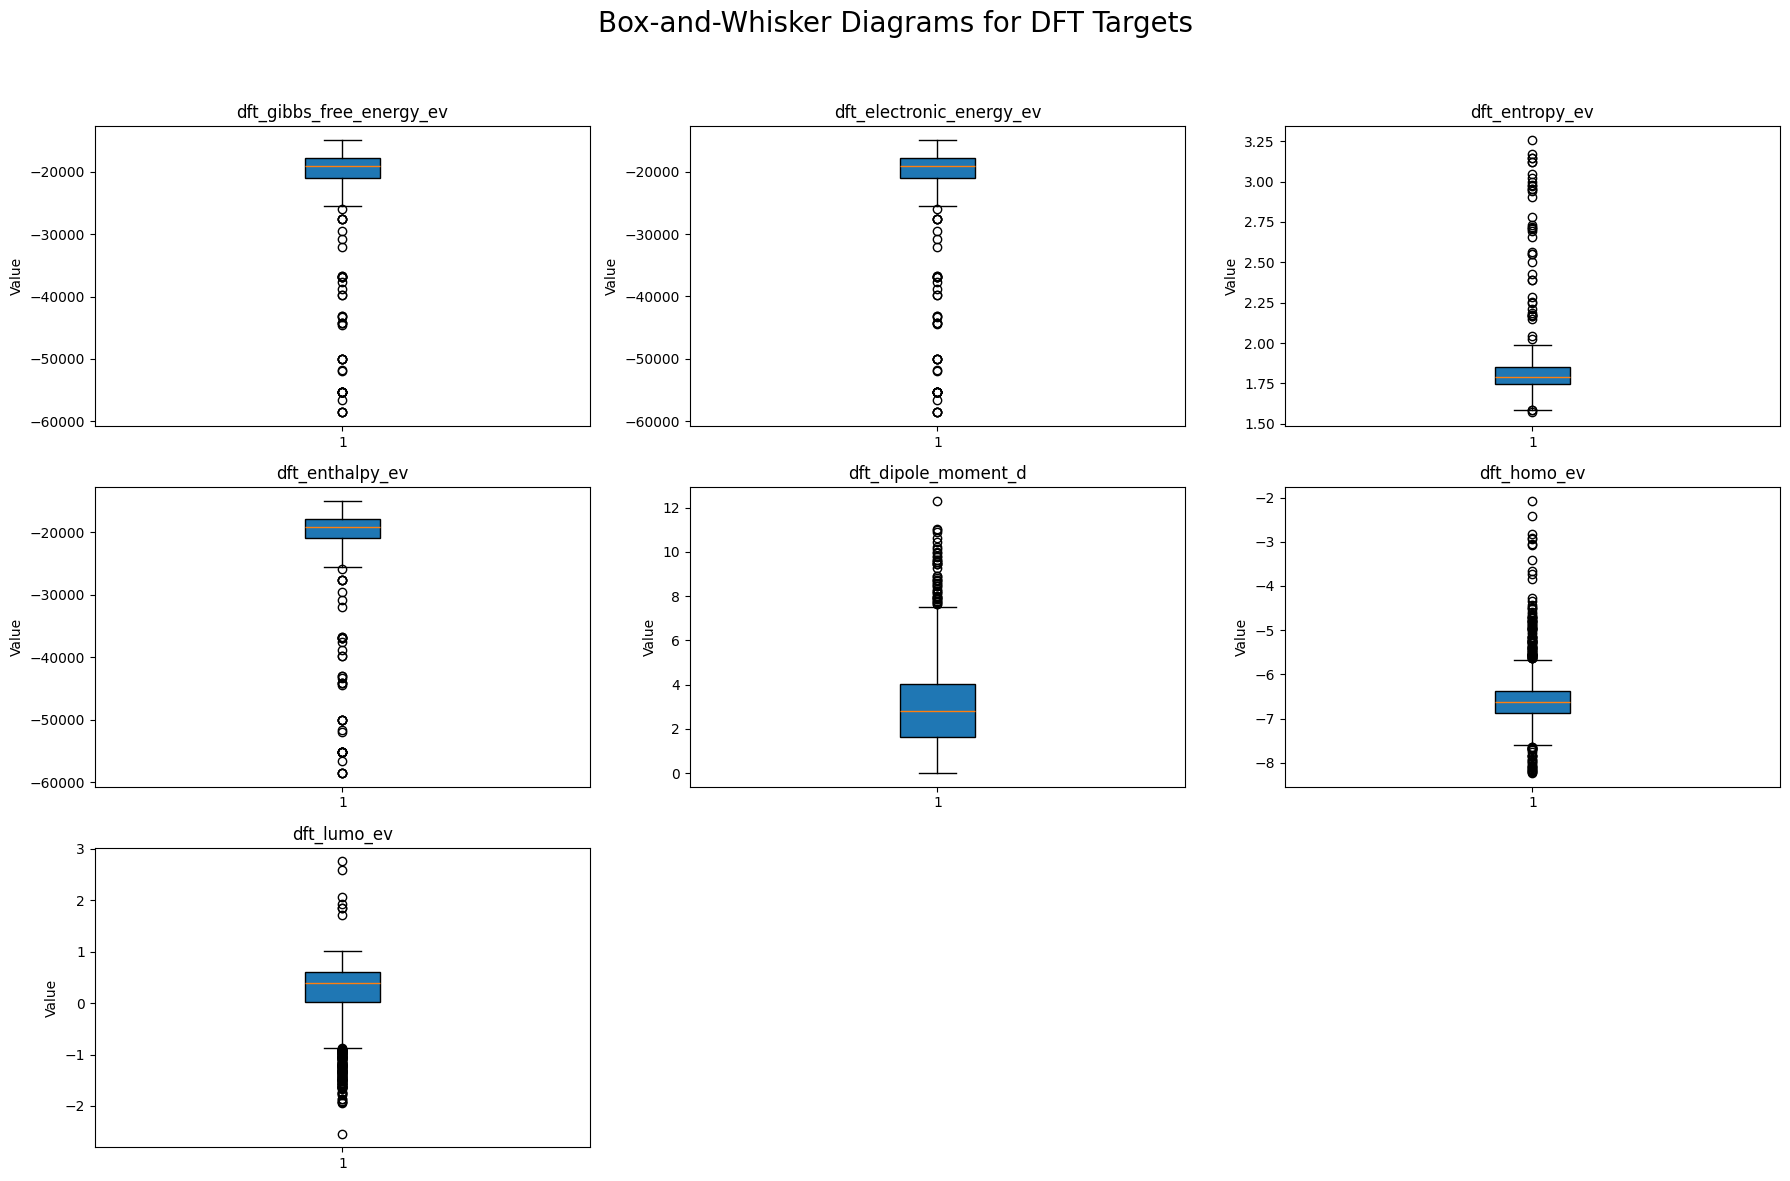

In [21]:
"""Разведочный анализ данных (EDA)"""
# DFT ("Ящик с усами")

plot_boxplots(dft_features, 'Box-and-Whisker Diagrams for DFT Targets')

In [22]:
"""Разведочный анализ данных (EDA)"""
# P-значения корреляции HF-3c признаков с каждым DFT таргетом

p_values = pd.DataFrame(index=hf_features, columns=dft_features)

for hf in hf_features:
    for dft in dft_features:
        _, p_value = pearsonr(df[hf], df[dft])
        p_values.loc[hf, dft] = p_value

print("\nP-values for correlations between HF features and DFT targets:\n", p_values)


P-values for correlations between HF features and DFT targets:
                         dft_gibbs_free_energy_ev dft_electronic_energy_ev  \
hf_gibbs_free_energy_ev                      0.0                      0.0   
hf_electronic_energy_ev                      0.0                      0.0   
hf_entropy_ev                                0.0                      0.0   
hf_enthalpy_ev                               0.0                      0.0   
hf_dipole_moment_d                      0.484399                 0.485858   
hf_homo_ev                                   0.0                      0.0   
hf_lumo_ev                                   0.0                      0.0   
mass_au                                      0.0                      0.0   

                        dft_entropy_ev dft_enthalpy_ev dft_dipole_moment_d  \
hf_gibbs_free_energy_ev            0.0             0.0            0.024124   
hf_electronic_energy_ev            0.0             0.0             0.02431   
hf_entr

In [23]:
"""Графовая сверточная нейросеть"""
# Делю на тренировочную, тестовую и валидационную выборки 
# 80 / 10 / 10

train_val_graphs, test_graphs = train_test_split(graph_data_list, test_size=0.1, random_state=42)
train_graphs, val_graphs = train_test_split(train_val_graphs, test_size=0.1, random_state=42)

print(f"Number of training graphs: {len(train_graphs)}")
print(f"Number of validation graphs: {len(val_graphs)}")
print(f"Number of test graphs: {len(test_graphs)}")

Number of training graphs: 855
Number of validation graphs: 95
Number of test graphs: 106


In [24]:
"""Графовая сверточная нейросеть"""
# Нормализация 
# Проверяю наличие пустых графов

empty_graphs = [i for i, graph in enumerate(graph_data_list) if graph.x.shape[0] == 0]
print(f"Empty graphs indices: {empty_graphs}")

Empty graphs indices: []


In [25]:
"""Графовая сверточная нейросеть"""
# Нормализация
# Отбрасываю пустые графы 

non_empty_graphs = [graph for graph in graph_data_list if graph.x.shape[0] > 0]

In [26]:
"""Графовая сверточная нейросеть"""
# Нормализация 
# Извлекаю все признаки для нормализации

node_features = np.vstack([graph.x.numpy() for graph in non_empty_graphs])
target_values = np.vstack([graph.y.numpy() for graph in graph_data_list])

feature_scaler = StandardScaler().fit(node_features)
target_scaler = StandardScaler().fit(target_values)

In [27]:
"""Графовая сверточная нейросеть"""
# Нормализация 
# Применяю нормализацию ко всем непустым графам 

for graph in graph_data_list:
    if graph.x.shape[0] > 0:
        graph.x = torch.tensor(feature_scaler.transform(graph.x.numpy()), dtype=torch.float)
        graph.y = torch.tensor(target_scaler.transform(graph.y.numpy().reshape(1, -1)), dtype=torch.float).view(-1)

In [28]:
"""Графовая сверточная нейросеть"""
# Нормализация 
# Нормализация тренировочного, валидационного и тестового сетов

for graph in train_graphs:
    if graph.x.shape[0] > 0:
        graph.x = torch.tensor(feature_scaler.transform(graph.x.numpy()), dtype=torch.float)
        graph.y = torch.tensor(target_scaler.transform(graph.y.numpy().reshape(1, -1)), dtype=torch.float).view(-1)

for graph in val_graphs:
    if graph.x.shape[0] > 0:
        graph.x = torch.tensor(feature_scaler.transform(graph.x.numpy()), dtype=torch.float)
        graph.y = torch.tensor(target_scaler.transform(graph.y.numpy().reshape(1, -1)), dtype=torch.float).view(-1)

for graph in test_graphs:
    if graph.x.shape[0] > 0:
        graph.x = torch.tensor(feature_scaler.transform(graph.x.numpy()), dtype=torch.float)
        graph.y = torch.tensor(target_scaler.transform(graph.y.numpy().reshape(1, -1)), dtype=torch.float).view(-1)

In [29]:
"""Графовая сверточная нейросеть"""
# Архитерктура
# Создаю класс ГСН, который принимает размеры входных и выходных слоев, инпутов & аутпутов, а также задает функцию активации 

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = torch.mean(x, dim=0) 
        x = self.fc(x)
        return x

In [30]:
"""Графовая сверточная нейросеть"""
# Архитерктура 
# Задаю размерности скрытых слоёв 
# Задаю размерности 'input'- и 'output'-признаков
# Задаю количество сверточных слоёв

input_dim = node_features.shape[1] 
hidden_dim = 80 
output_dim = 7
num_layers = 4 

In [31]:
"""Графовая сверточная нейросеть"""
# Создаю и обучаю ГСН-модель
# Применил "Early Stopping" для исключения возможности переобучения
# Веса лучшей эпохи сохранил 

model = GCN(input_dim, hidden_dim, output_dim, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

def train(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
        return output.numpy()

num_epochs = 300
patience = 10
min_delta = 0.0001
best_val_loss = float('inf')
epochs_no_improve = 0

best_model_weights = None

for epoch in range(num_epochs):
    total_loss = 0
    for data in train_graphs:
        total_loss += train(model, optimizer, criterion, data)
    avg_train_loss = total_loss / len(train_graphs)
    
    val_losses = []
    for data in val_graphs:
        model_output = evaluate(model, data)
        target = data.y.numpy()
        val_loss = mean_squared_error(target, model_output)
        val_losses.append(val_loss)
    avg_val_loss = np.mean(val_losses)
    
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_weights = model.state_dict()
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == patience:
        print(f'Early stopping after {epoch + 1} epochs.')
        break

if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

Epoch 1, Train Loss: 8.1790, Val Loss: 3.8334
Epoch 2, Train Loss: 2.4125, Val Loss: 2.4706
Epoch 3, Train Loss: 1.3462, Val Loss: 1.0032
Epoch 4, Train Loss: 0.7133, Val Loss: 0.5006
Epoch 5, Train Loss: 0.5271, Val Loss: 0.3679
Epoch 6, Train Loss: 0.4558, Val Loss: 0.3283
Epoch 7, Train Loss: 0.4252, Val Loss: 0.3139
Epoch 8, Train Loss: 0.4255, Val Loss: 0.3069
Epoch 9, Train Loss: 0.4011, Val Loss: 0.3039
Epoch 10, Train Loss: 0.3772, Val Loss: 0.3031
Epoch 11, Train Loss: 0.3713, Val Loss: 0.3030
Epoch 12, Train Loss: 0.3629, Val Loss: 0.3011
Epoch 13, Train Loss: 0.3509, Val Loss: 0.3012
Epoch 14, Train Loss: 0.3452, Val Loss: 0.3017
Epoch 15, Train Loss: 0.3398, Val Loss: 0.3004
Epoch 16, Train Loss: 0.3287, Val Loss: 0.3015
Epoch 17, Train Loss: 0.3238, Val Loss: 0.3006
Epoch 18, Train Loss: 0.3176, Val Loss: 0.3006
Epoch 19, Train Loss: 0.3146, Val Loss: 0.2985
Epoch 20, Train Loss: 0.3066, Val Loss: 0.2973
Epoch 21, Train Loss: 0.3043, Val Loss: 0.2967
Epoch 22, Train Loss: 

In [32]:
"""Графовая сверточная нейросеть"""
# Оцениваю модель на тестовой выборке
# Применяю inverse_tranform()

test_losses = []
test_predictions = []
original_targets = []

for data in test_graphs:
    model_output = evaluate(model, data)
    target = data.y.numpy()
    test_loss = criterion(torch.tensor(model_output), torch.tensor(target)).item()
    test_losses.append(test_loss)
    
    model_output_unscaled = target_scaler.inverse_transform(model_output.reshape(1, -1)).flatten()
    test_predictions.append(model_output_unscaled)
    
    original_target_unscaled = target_scaler.inverse_transform(target.reshape(1, -1)).flatten()
    original_targets.append(original_target_unscaled)

average_test_loss = np.mean(test_losses)
print(f"Average Test Loss of Scaled Data: {average_test_loss}")

mae = mean_absolute_error(np.concatenate(original_targets), np.concatenate(test_predictions))
print(f"Average Mean Absolute Error (MAE) of Inversed Data: {mae}")

Average Test Loss of Scaled Data: 0.7159886018742087
Average Mean Absolute Error (MAE) of Inversed Data: 85.199462890625


In [33]:
"""Графовая сверточная нейросеть"""
# Значения МАЕ для всех таргетов

target_names = ['dft_gibbs_free_energy_ev', 'dft_electronic_energy_ev', 'dft_entropy_ev',
                'dft_enthalpy_ev', 'dft_dipole_moment_d', 'dft_homo_ev', 'dft_lumo_ev']

def visualize_results(model, test_graphs):
    model.eval()
    with torch.no_grad():
        predicted_values = []
        actual_values = []
        
        for data in test_graphs:
            model_output = evaluate(model, data)
            predicted_values.append(model_output) 
            actual_values.append(data.y.numpy()) 
        
        return predicted_values, actual_values
    
predicted_values, actual_values = visualize_results(model, test_graphs)

print(f"Number of predicted values: {len(predicted_values)}")
print(f"Number of actual values: {len(actual_values)}")

predicted_values = np.array(predicted_values)
actual_values = np.array(actual_values)

if len(actual_values) == 0 or len(predicted_values) == 0:
    print("No data points collected for inverse transformation.")
else:
    predicted_values_inv = target_scaler.inverse_transform(predicted_values)
    actual_values_inv = target_scaler.inverse_transform(actual_values)

    mae_values = []
    for i in range(actual_values.shape[1]): 
        mae = mean_absolute_error(actual_values_inv[:, i], predicted_values_inv[:, i])
        mae_values.append(mae)
        print(f'MAE for {target_names[i]}: {mae:.4f}')

    average_test_loss = np.mean(mae_values)
    print(f"Average Test Loss (MAE): {average_test_loss:.4f}")

Number of predicted values: 106
Number of actual values: 106
MAE for dft_gibbs_free_energy_ev: 213.2442
MAE for dft_electronic_energy_ev: 204.2279
MAE for dft_entropy_ev: 0.1703
MAE for dft_enthalpy_ev: 177.6998
MAE for dft_dipole_moment_d: 0.4117
MAE for dft_homo_ev: 0.2159
MAE for dft_lumo_ev: 0.4264
Average Test Loss (MAE): 85.1995
